# Tarea de Programación: Construcción de un Pipeline de Datos Robusto

Bienvenido a la tarea de Gestión de Datos en PyTorch.

En ejemplos anteriores, has trabajado con conjuntos de datos limpios y preempaquetados. En la realidad, los datos rara vez son así de simples. En visión computacional, las imágenes suelen venir en diferentes tamaños y formatos, y deben ser preprocesadas antes de que un modelo pueda aprender de ellas. Manejar esto manualmente para miles de imágenes sería tanto tedioso como propenso a errores.

En esta tarea, trabajarás con el conjunto de datos [Plants Classification](https://www.kaggle.com/datasets/marquis03/plants-classification), que contiene 30,000 imágenes `.jpg` de 30 especies de plantas como aloe vera, plátano, espinaca y sandía. Como muchos conjuntos de datos del mundo real, las imágenes varían en tamaño y calidad, y están organizadas en carpetas por clase. Para este ejercicio, utilizarás un subconjunto de 3,000 imágenes.

Aquí es donde entra en juego un pipeline de datos. Obtendrás experiencia práctica construyendo un dataset personalizado, aplicando las transformaciones necesarias y cargando tus datos en lotes (batches). Estos son los primeros pasos esenciales antes de entrenar un modelo de aprendizaje profundo.

**Lo que harás en esta tarea**

* Acceder y explorar la estructura de un conjunto de datos de imágenes.
* Construir una clase `Dataset` personalizada para cargar tus imágenes y etiquetas bajo demanda.
* Definir una serie de `transformaciones`, incluyendo el cambio de tamaño, la conversión a tensores y la `normalización`, para preprocesar los datos.
* Definir transformaciones de aumento (augmentation) para mejorar el conjunto de datos de entrenamiento.
* Dividir el conjunto de datos en grupos de entrenamiento, validación y prueba, aplicando las transformaciones adecuadas a cada uno y creando instancias de `DataLoader` para un procesamiento por lotes eficiente.

¡Empecemos!

---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">CONSEJOS PARA UNA CALIFICACIÓN EXITOSA DE TU TAREA:</h4>

* Todas las celdas están bloqueadas, excepto aquellas donde debes enviar tus soluciones o cuando se mencione explícitamente que puedes interactuar con ellas.

* En cada celda de ejercicio, busca los comentarios `### START CODE HERE ###` y `### END CODE HERE ###`. Estos te indican dónde escribir el código de tu solución. **No agregues ni cambies ningún código que esté fuera de estos comentarios**.

* Puedes agregar nuevas celdas para experimentar, pero estas serán omitidas por el calificador, así que no dependas de celdas creadas recientemente para alojar el código de tu solución; utiliza los lugares proporcionados para ello.

* Evita el uso de variables globales a menos que sea absolutamente necesario. El calificador prueba tu código en un entorno aislado sin ejecutar todas las celdas desde el principio. Como resultado, las variables globales podrían no estar disponibles al calificar tu entrega. Las variables globales que están destinadas a ser utilizadas estarán definidas en MAYÚSCULAS.

* Para enviar tu cuaderno para calificación, primero guárdalo haciendo clic en el icono 💾 en la parte superior izquierda de la página y luego haz clic en el botón `Submit assignment` en la parte superior derecha de la página.
---

## Table of Contents
- [Imports](#imports)
- [1 - Data Access](#1---data-access)
    - [1.1 - Exploring the Dataset](#11---exploring-the-dataset)
    - [1.2 - Creating a Custom Dataset Class](#12---creating-a-custom-dataset-class)
        - **[Exercise 1 - PlantsDataset](#exercise-1---plantsdataset)**
    - [1.3 - Overview of the images in the dataset](#13---overview-of-the-images-in-the-dataset)
- [2 - Transformations](#2---transformations)
    - [2.1 - Computing Mean and Standard Deviation](#21---computing-mean-and-standard-deviation)
    - [2.2 - Defining Transformations](#22---defining-transformations)
        - **[Exercise 2 - get_transformations](#exercise-2---get_transformations)**
- [3 - Data Loading](#3---data-loading)
    - **[Exercise 3 - get_data_loaders](#exercise-3---get_data_loaders)**

<a name='imports'></a>
## Imports

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, Subset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

In [2]:
from tqdm.auto import tqdm
import helper_utils
#import unittests

<a name='1---data-access'></a>
## 1 - Data Access 

<a name='11---exploring-the-dataset'></a>
### 1.1 - Explorando el Dataset

Como ya has aprendido, el primer paso al trabajar con cualquier conjunto de datos nuevo es explorarlo. Esto implica comprender su estructura, los tipos de datos que contiene e identificar cualquier problema potencial, como valores faltantes o valores atípicos (outliers).

En este paso, utilizarás la función `print_data_folder_structure` de `helper_utils` para imprimir la disposición de las carpetas del dataset. 
Esto te ayudará a ver cómo están organizados los archivos y directorios, un paso crucial antes de comenzar a cargar y preprocesar los datos.

In [3]:
path_dataset = './plants_dataset'

helper_utils.print_data_folder_structure(path_dataset, max_depth=1)

plants_dataset/
├── classname.txt
├── df_labels.csv
├── df_labels_orig.csv
├── aloevera/
├── banana/
├── bilimbi/
├── cantaloupe/
├── cassava/
├── coconut/
├── corn/
├── cucumber/
├── curcuma/
├── eggplant/
├── galangal/
├── ginger/
├── guava/
├── kale/
├── longbeans/
├── mango/
├── melon/
├── orange/
├── paddy/
├── papaya/
├── peperchili/
├── pineapple/
├── pomelo/
├── shallot/
├── soybeans/
├── spinach/
├── sweetpotatoes/
├── tobacco/
├── waterapple/
└── watermelon/


Ya tienes una comprensión inicial de la estructura del dataset:
- `df_labels.csv`,
- `classname.txt`,
- Una carpeta por clase, cada una con las imágenes de esa clase (todas en formato `.jpg`).

Esta información será útil cuando diseñes tu clase Dataset personalizada más adelante.

In [4]:
# print the content of `df_labels.csv`
df_labels = pd.read_csv(f'{path_dataset}/df_labels.csv')
print(df_labels.head())

                 image:FILE  category
0  aloevera/aloevera700.jpg         0
1  aloevera/aloevera701.jpg         0
2  aloevera/aloevera702.jpg         0
3  aloevera/aloevera703.jpg         0
4  aloevera/aloevera704.jpg         0


In [5]:
# print the content of `classname.txt`
with open(f'{path_dataset}/classname.txt', 'r') as f:
    class_names = f.read().splitlines()
print(class_names)

['aloevera', 'banana', 'bilimbi', 'cantaloupe', 'cassava', 'coconut', 'corn', 'cucumber', 'curcuma', 'eggplant', 'galangal', 'ginger', 'guava', 'kale', 'longbeans', 'mango', 'melon', 'orange', 'paddy', 'papaya', 'peperchili', 'pineapple', 'pomelo', 'shallot', 'soybeans', 'spinach', 'sweetpotatoes', 'tobacco', 'waterapple', 'watermelon']


Has verificado que `df_labels.csv` contiene las etiquetas para cada imagen junto con sus nombres de archivo correspondientes, y que `classname.txt` contiene los nombres de todas las clases.

<a name='12---creating-a-custom-dataset-class'></a>
### 1.2 - Creación de una Clase Dataset Personalizada

Ha llegado el momento de crear una clase de dataset personalizada para manejar el conjunto de datos de imágenes de plantas. 
Esta clase heredará de `torch.utils.data.Dataset` y será responsable de cargar y preprocesar las imágenes junto con sus etiquetas correspondientes.

<a name='exercise-1---plantsdataset'></a>
#### **Ejercicio 1 - `PlantsDataset`**

**Tu tarea:**

Tu tarea es completar la implementación de la clase de Dataset personalizada de PyTorch `PlantsDataset`. 
Debes implementar el código faltante en varias secciones dentro de la clase:

* **Completa el método `__init__`**:
    * Carga las etiquetas desde el DataFrame utilizando el método `load_labels` ya definido en el atributo `.df_info`.
    * Crea un mapeo de enteros de etiquetas a nombres de clases utilizando el método `read_classname` ya definido.

* **Completa el método `__len__`**:
    * Devuelve el número total de muestras en el conjunto de datos extrayendo la longitud del atributo `.labels`.

* **Completa el método `__getitem__`**:
    * Recupera la imagen en el índice especificado utilizando el método `retrieve_image` existente.
    * Aplica transformaciones a la imagen si están especificadas.
    * Obtén la etiqueta correspondiente del atributo `.labels`.

<details>
  <summary><b><font color="green">Consejos de código adicionales (Haz clic para expandir si te quedas atascado)</font></b></summary>
  
Si necesitas un poco de ayuda, aquí tienes una guía más detallada para cada método:

**Para el método `__init__`:**
* Para `self.labels`: Llama a `self.load_labels()` para extraer las etiquetas del DataFrame `self.df_info`.

**Para el método `__len__`:**
* Usa la función integrada `len()` sobre `self.labels`.

**Para el método `__getitem__`:**
* Usa `self.retrieve_image(idx)` para obtener la imagen en el índice especificado.
* Si `self.transform` no es None, aplícalo a la imagen usando `self.transform(image)`.
* Obtén la etiqueta de `self.labels[idx]`.

</details>

In [6]:
# GRADED CLASS: PlantsDataset
class PlantsDataset(Dataset):
    """
    Una clase de dataset personalizada para cargar imágenes de plantas y sus etiquetas correspondientes.

    Args:
        root_dir (str): Directorio raíz que contiene los archivos del dataset, incluyendo 'classname.txt'.
        transform (callable, opcional): Transformación opcional que se aplicará sobre una muestra.

    Atributos:
        root_dir (str): Ruta al directorio raíz del dataset.
        transform (callable): Transformaciones para aplicar a las imágenes.
        df_info (pd.DataFrame): DataFrame que contiene los nombres de los archivos de imagen y las etiquetas de categoría.
        labels (list): Lista de etiquetas enteras para cada imagen.
        class_names (list): Lista de nombres de clase correspondientes a los índices de las etiquetas.
    """

    def __init__(self, root_dir, transform=None):
        """
        Inicializa el objeto del dataset.

        Args:
            root_dir (str): Ruta al directorio raíz que contiene el dataset.
            transform (callable, opcional): Transformación opcional que se aplicará sobre una muestra.
        """

        # Inicializar la ruta al directorio raíz y las transformaciones
        self.root_dir = root_dir
        self.transform = transform

        # Leer el archivo CSV (con la ruta de las imágenes y las etiquetas de categoría)
        self.df_info = self.read_df()

        ### START CODE HERE ###

        # Cargar las etiquetas del DataFrame usando el método `load_labels`
        self.labels = self.load_labels(self.df_info)

        # Crear un mapeo de enteros de etiquetas a nombres de clases usando el método `read_classname`
        self.class_names = self.read_classname()

        ### END CODE HERE ###

    def read_df(self):
        """
        Lee un archivo CSV de la ruta especificada y lo devuelve como un DataFrame de pandas.
        """
        path_csv = self.root_dir + "/df_labels.csv"
        df = pd.read_csv(path_csv)
        return df

    def read_classname(self):
        """
        Lee los nombres de las clases de un archivo llamado 'classname.txt' ubicado en el directorio raíz.

        Retorna:
            list: Una lista de nombres de clases, cada uno como una cadena, leída del archivo.
        """
        path_txt = self.root_dir + "/classname.txt"
        with open(path_txt, "r") as f:
            class_names = f.read().splitlines()
        return class_names

    def load_labels(self, df):
        """
        Extrae etiquetas enteras de un DataFrame y las devuelve como una lista.
        """
        labels = []

        for idx, row in df.iterrows():
            label_int = row["category"]
            labels.append(label_int)
        return labels

    def get_label_description(self, label: int):
        """
        Devuelve la descripción de una etiqueta de clase.
        """
        description = self.class_names[label]
        return description

    def retrieve_image(self, idx: int):
        """
        Recupera y devuelve de la carpeta la imagen PIL en el índice especificado.
        Convierte la imagen a modo RGB.
        """
        img_path = self.root_dir + "/" + self.df_info.iloc[idx]["image:FILE"]
        with Image.open(img_path) as img:
            image = img.convert("RGB")
        return image

    ### START CODE HERE ###

    def __len__(self):
        """
        Devuelve el número de muestras en el dataset.
        """
        # Devolver el número total de muestras del atributo `.labels`
        length = len(self.labels)
        return length

    def __getitem__(self, idx):
        """
        Recupera la imagen y su etiqueta correspondiente en el índice especificado.

        Args:
            idx (int): Índice del elemento a recuperar.

        Retorna:
            tuple: Una tupla (image, label) donde:
                - image: La imagen en el índice dado, posiblemente transformada si se especifica una transformación.
                - label: La etiqueta correspondiente a la imagen.
        """
        # Recuperar la imagen usando el método `retrieve_image`
        image = self.retrieve_image(idx)

        # Aplicar las transformaciones especificadas a la imagen, si las hay
        # El None de la condición if no es parte del ejercicio, déjalo como está
        if self.transform is not None:
            image = self.transform(image)

        # Recuperar la etiqueta del atributo `labels`
        label = self.labels[idx]

        # Retornar la imagen y la etiqueta
        return image, label  

    ### END CODE HERE ###

In [7]:
plants_dataset = PlantsDataset(root_dir=path_dataset, transform=None)

In [8]:
# print the length of the dataset
print(f'Length of the dataset: {len(plants_dataset)}')

Length of the dataset: 3000


Description: aloevera
Image shape: (269, 187)



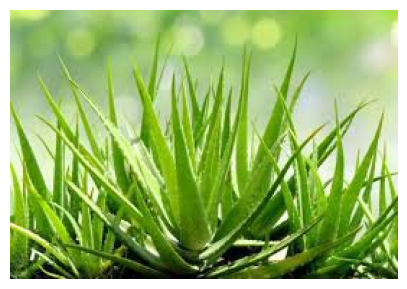

In [9]:
# Look at a sample to check it's working correctly
sel_idx = 10
img, label = plants_dataset[sel_idx]

# Visualize the image
helper_utils.plot_img(img)

# Print its description
print(f'Description: {plants_dataset.get_label_description(label)}')

# Print its shape
print(f'Image shape: {img.size}\n')  # PIL image size is (width, height)

##### **Expected Output**
```
Description: aloevera
Image shape: (269, 187)
```

![exp_out_1.png](exp_out_1.png)

In [ ]:
# Test your code!
unittests.exercise_1(PlantsDataset)

<a name='13---overview-of-the-images-in-the-dataset'></a>
### 1.3 - Descripción General de las Imágenes en el Dataset

Las imágenes ahora son accesibles a través de la clase de dataset personalizada que implementaste en el ejercicio anterior. Sin embargo, aún no han sido preprocesadas, un paso necesario antes de introducirlas en una red neuronal.

En este paso, explorarás el dataset utilizando la función `visual_exploration` de `helper_utils`. Esta función muestra algunas imágenes de muestra junto con sus etiquetas, lo que te permite inspeccionar visualmente los datos y tener una idea de sus características principales.

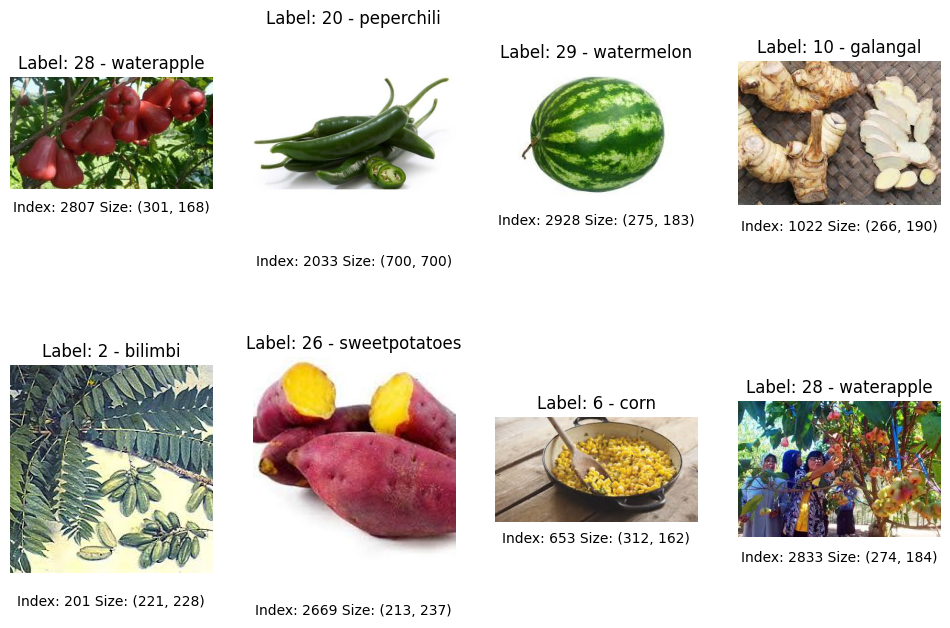

In [13]:
helper_utils.visual_exploration(plants_dataset, num_rows=2, num_cols=4)

A partir de la exploración visual, puedes ver que las imágenes en el conjunto de datos varían en tamaño, color y fondo. 
Este tipo de variabilidad es común en los conjuntos de datos del mundo real y subraya la importancia de los pasos de preprocesamiento, como el cambio de tamaño, la normalización y el aumento de datos, para ayudar al modelo a generalizarse de manera efectiva a través de diferentes tipos de imágenes.

<a name='2---transformations'></a>
## 2 - Transformaciones

Antes de introducir imágenes en una red neuronal, es necesario preprocesarlas mediante una serie de transformaciones. Estos pasos incluyen cambiar el tamaño de las imágenes a una dimensión consistente, convertirlas en tensores y normalizar sus valores de píxeles.

<a name='21---computing-mean-and-standard-deviation'></a>

### 2.1 - Cálculo de la Media y la Desviación Estándar

A continuación se presenta una función auxiliar `get_mean_std` que calcula la media y la desviación estándar del conjunto de datos de entrenamiento. Estas estadísticas son necesarias para el paso de normalización en el pipeline de preprocesamiento.

Dado que cambiar el tamaño y convertir las imágenes en tensores modifica la distribución de los valores de los píxeles, la media y la desviación estándar deben calcularse después de aplicar estas transformaciones.

En `get_mean_std`, realizarás lo siguiente:

* **Configuración del Preprocesamiento**: 
Un pipeline de transformación cambia el tamaño de las imágenes a 128×128 y las convierte en tensores.

* **Primera Pasada — Calcular la Media**: 
Para cada imagen, los píxeles se aplanan y los valores de los píxeles por canal se suman globalmente a lo largo de todo el conjunto de datos. Al dividir por el número total de píxeles se obtiene la media por canal.

* **Segunda Pasada — Calcular la Desviación Estándar**: 
Con la media conocida, calculamos la diferencia al cuadrado entre cada píxel y su media de canal, acumulamos a través del conjunto de datos y luego tomamos la raíz cuadrada para obtener la desviación estándar por canal.

**Nota**: 
La media y la desviación estándar normalmente deben calcularse solo en el conjunto de entrenamiento. El uso de estadísticas calculadas a partir de los datos de prueba o validación puede introducir una fuga de datos (data leakage), donde la información del conjunto de evaluación influye en el proceso de entrenamiento. En este caso, dado que en este punto los datos aún no se han dividido, calcularás las estadísticas sobre todo el conjunto de datos por simplicidad. Los valores de media y desviación estándar que obtengas aquí no variarán mucho cuando se calculen únicamente sobre el conjunto de entrenamiento.

In [34]:
def get_mean_std(dataset: Dataset):
    # Define la secuencia de redimensionamiento y conversión a tensor
    preprocess = transforms.Compose(
        [transforms.Resize((128, 128)), 
         transforms.ToTensor()]
    )
    
    # Pasada 1: Cálculo de la Media
    total_pixels = 0
    sum_pixels = torch.zeros(3)
    
    # [Visual] Envolver el dataset en tqdm para crear el iterador de la barra de progreso
    mean_loader = tqdm(dataset, desc="Pasada 1/2: Calculando Media")
    
    for img, _ in mean_loader:
        # Cálculo principal para la media
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1) # [canales, píxeles]
        sum_pixels += pixels.sum(dim=1)
        total_pixels += pixels.size(1)
    
    mean = sum_pixels / total_pixels
    
    # Pasada 2: Cálculo de la Desviación Estándar
    sum_squared_diff = torch.zeros(3)
    
    # [Visual] Envolver el dataset en tqdm para crear el iterador de la barra de progreso
    std_loader = tqdm(dataset, desc="Pasada 2/2: Calculando Desviación Estándar")
    
    for img, _ in std_loader:
        # Cálculo principal para la desviación estándar
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1) # [canales, píxeles]
        diff = pixels - mean.unsqueeze(1)
        sum_squared_diff += (diff ** 2).sum(dim=1)
    
    std = torch.sqrt(sum_squared_diff / total_pixels)
    
    return mean, std

In [35]:
# Define the transformations to make to the images
mean, std = get_mean_std(plants_dataset)

print(f"\nMean: {mean}")
print(f" Std: {std}")

Pasada 1/2: Calculando Media:   0%|          | 0/3000 [00:00<?, ?it/s]

Pasada 2/2: Calculando Desviación Estándar:   0%|          | 0/3000 [00:00<?, ?it/s]


Mean: tensor([0.6659, 0.6203, 0.4784])
 Std: tensor([0.2888, 0.2884, 0.3426])


<br>
<details>
<summary><b>El Algoritmo Principal (Sin Barra de Progreso)</b></summary>
<br>
La implementación de la función anterior utiliza <code>tqdm</code> para proporcionar un indicador visual de la velocidad de iteración y el tiempo estimado restante.

Es importante entender que envolver el dataset en `tqdm(dataset)` no cambia los datos ni las matemáticas. El iterador produce exactamente las mismas imágenes en el mismo orden.

Si eliminas la lógica de la interfaz de usuario para enfocarte estrictamente en el <b>Algoritmo Matemático</b>, la implementación se ve así:

```python
def get_mean_std(dataset: Dataset):
    preprocess = transforms.Compose(
        [transforms.Resize((128, 128)), transforms.ToTensor()]
    )
    
    # Pasada 1: Cálculo de la Media
    total_pixels = 0
    sum_pixels = torch.zeros(3)
    
    # Iterar directamente sobre el dataset sin el envoltorio visual (tqdm)
    for img, _ in dataset:
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)  # [canales, píxeles]
        sum_pixels += pixels.sum(dim=1)
        total_pixels += pixels.size(1)
    
    mean = sum_pixels / total_pixels
    
    # Pasada 2: Cálculo de la Desviación Estándar
    sum_squared_diff = torch.zeros(3)
    
    for img, _ in dataset:
        img_tensor = preprocess(img)
        pixels = img_tensor.view(3, -1)  # [canales, píxeles]
        diff = pixels - mean.unsqueeze(1)
        sum_squared_diff += (diff ** 2).sum(dim=1)
    
    std = torch.sqrt(sum_squared_diff / total_pixels)
    
    return mean, std

<a name='22---defining-transformations'></a>
### 2.2 - Definiendo Transformaciones

Habiendo calculado la media y la desviación estándar del dataset, ahora puedes definir las transformaciones que se aplicarán a las imágenes.
Crearás dos conjuntos de transformaciones: uno para el conjunto de entrenamiento, que incluye aumento de datos (data augmentation), y otro para los conjuntos de validación y prueba.

<a name='exercise-2---get_transformations'></a>
#### **Ejercicio 2 - `get_transformations`**

**Tu tarea:**

Tu tarea es implementar el código faltante en la función `get_transformations` para crear dos pipelines de transformación de imágenes para PyTorch.

Implementarás las siguientes secciones:

* **Definir `main_tfs`**:
    * Crea una transformación `Resize` para cambiar el tamaño de las imágenes a 128x128 píxeles.
    * Crea una transformación `ToTensor` para convertir imágenes PIL en tensores de PyTorch.
    * Crea una transformación `Normalize` utilizando los valores de media (mean) y desviación estándar (std) proporcionados.

* **Definir `augmentation_tfs`**:
    * Crea una transformación `RandomVerticalFlip` con una probabilidad del 50%.
    * Crea una transformación `RandomRotation` que rote las imágenes ±15 grados.

* **Componer los Pipelines de Transformación**:
    * Crea `main_transform` combinando las transformaciones principales en un solo pipeline usando `transforms.Compose`.
    * Crea `transform_with_augmentation` combinando tanto las transformaciones de aumento como las principales en un pipeline aumentado.
    Las transformaciones de aumento deben aplicarse antes de las transformaciones principales.

<details>
  <summary><b><font color="green">Consejos de código adicionales (Haz clic para expandir si te quedas atascado)</font></b></summary>

Si necesitas un poco de ayuda, aquí tienes una guía más detallada para cada sección:

**Para `main_tfs`:**
* Para `Resize`: Usa `transforms.Resize((128, 128))` para redimensionar todas las imágenes a 128x128 píxeles.
* Para `ToTensor`: Usa `transforms.ToTensor()` para convertir imágenes PIL en tensores de PyTorch.
* Para `Normalize`: Usa `transforms.Normalize(mean=mean, std=std)` con los parámetros de media y std proporcionados.

**Para `augmentation_tfs`:**
* Para `RandomVerticalFlip`: Usa `transforms.RandomVerticalFlip(p=0.5)` para voltear imágenes verticalmente con un 50% de probabilidad.
* Para `RandomRotation`: Usa `transforms.RandomRotation(degrees=15)` para rotar imágenes aleatoriamente dentro de un rango de ±15 grados.

**Para componer transformaciones:**
* Para `main_transform`: Usa `transforms.Compose(main_tfs)` para combinar la lista de transformaciones principales.
* Para `transform_with_augmentation`: Usa `transforms.Compose(augmentation_tfs + main_tfs)` para combinar ambas listas.

</details>

In [36]:
# GRADED FUNCTION : get_transformations
def get_transformations(mean, std):
    """
    Devuelve dos conjuntos de pipelines de transformación de imágenes: uno con preprocesamiento básico y otro con aumento de datos adicional.

    Args:
        mean: Secuencia de valores de media para la normalización.
        std: Secuencia de valores de desviación estándar para la normalización.

    Returns:
        main_transform: Pipeline de transformación con redimensionamiento, conversión a tensor y normalización.
        transform_with_augmentation: Pipeline de transformación que incluye volteo vertical aleatorio, rotación aleatoria, redimensionamiento, conversión a tensor y normalización.
    """
    ### START CODE HERE ###
    main_tfs = [
        # Redimensionar las imágenes a 128x128 píxeles
        transforms.Resize((128, 128)),
        # Convertir las imágenes a tensores de PyTorch
        transforms.ToTensor(),
        # Normalizar las imágenes usando la media (mean) y desviación estándar (std) proporcionadas
        transforms.Normalize(mean=mean, std=std)
    ]

    augmentation_tfs =[  
        # Voltear la imagen verticalmente de forma aleatoria
        transforms.RandomVerticalFlip(p=0.5),
        # Rotar la imagen aleatoriamente en ±15 grados
        transforms.RandomRotation(15)
    ]

    # Componer las transformaciones principales en un solo pipeline
    main_transform = transforms.Compose(main_tfs)

    transform_with_augmentation = transforms.Compose(augmentation_tfs + main_tfs)
    ### END CODE HERE ###
    return main_transform, transform_with_augmentation

In [37]:
# Get the transformations
main_transform, transform_with_augmentation = get_transformations(mean, std)

# Print the transformations to verify
print(main_transform)
print(transform_with_augmentation)

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)


##### **Expected Output**

```
Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
```

In [ ]:
# Test your code!
unittests.exercise_2(get_transformations)

Puedes verificar tus transformaciones aplicándolas a una imagen de muestra del dataset e inspeccionando el resultado.

Transformed Image shape: torch.Size([3, 128, 128])



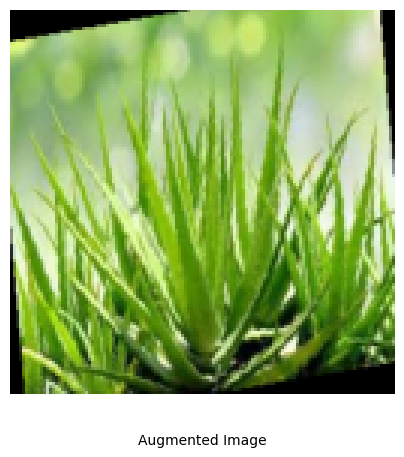

In [38]:
# Check main_transform on a sample image
img_transformed = main_transform(img)
print(f"Transformed Image shape: {img_transformed.shape}\n")


# get denormalization function
denormalize = helper_utils.Denormalize(mean, std)
# visualize the augmented image
img_augmented = transform_with_augmentation(img)
helper_utils.plot_img(denormalize(img_augmented), info=f"Augmented Image")

<a name='3---data-loading'></a>
## 3 - Carga de Datos (Data Loading)

Con tu clase de dataset personalizada y las transformaciones definidas, ahora puedes crear cargadores de datos (data loaders) para cargar y agrupar los datos en lotes (batches) de manera eficiente para el entrenamiento y la evaluación. Este es el paso final antes de que pudieras entrenar una red neuronal con este conjunto de datos.

Al igual que en el laboratorio anterior, después de usar `random_split` para dividir el dataset en conjuntos de entrenamiento, validación y prueba, debes asegurarte de que cada subconjunto utilice las transformaciones adecuadas. 
Una forma de cambiar las transformaciones de cada subconjunto es envolviéndolos en nuevas instancias de la clase de dataset personalizada `SubsetWithTransform`.

In [42]:
class SubsetWithTransform(Dataset):
    """A subset of a dataset with a specific transform applied."""

    def __init__(self, subset: Subset, transform=None):
        # subset should be a subset WITHOUT transform
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

<a name='exercise-3---get_data_loaders'></a>
#### **Ejercicio 3 - `get_data_loaders`**

**Tu tarea:**

Tu tarea es completar la implementación de la función `get_dataloaders` para dividir un dataset y crear DataLoaders de PyTorch para el entrenamiento, la validación y las pruebas.
Debes implementar el código faltante en tres secciones principales:

* **Dividir el Dataset**:
    * Usa `random_split` para dividir el dataset en conjuntos de entrenamiento, validación y prueba basados en los tamaños calculados.

* **Aplicar Transformaciones a cada División**:
    * Envuelve cada división del dataset con `SubsetWithTransform` para aplicar las transformaciones adecuadas.
    * Usa `augmentation_transform` para el conjunto de entrenamiento para incluir el aumento de datos.
    * Usa `main_transform` tanto para el conjunto de validación como para el de prueba (no se necesita aumento).

* **Crear DataLoaders**:
    * Crea objetos `DataLoader` para cada división del dataset con el tamaño de lote (batch size) especificado.
    * Habilita el barajado (`shuffling`) para el cargador de entrenamiento para aleatorizar el orden de los lotes.
    * Deshabilita el barajado para los cargadores de validación y prueba para mantener una evaluación consistente.

<details>
  <summary><b><font color="green">Consejos de código adicionales (Haz clic para expandir si te quedas atascado)</font></b></summary>
  
Si necesitas un poco de ayuda, aquí tienes una guía más detallada para cada sección:

**Para dividir el dataset:**
* Usa `random_split(dataset, [train_size, val_size, test_size])` para dividir el dataset.

**Para aplicar transformaciones:**
* Usa `SubsetWithTransform(dataset_split, transform=transform_to_apply)` para cada división.

**Para crear DataLoaders:**
* Usa `DataLoader(dataset=dataset_split, batch_size=batch_size, shuffle=shuffle_setting)`.
* Para el cargador de entrenamiento: establece `shuffle=True` para aleatorizar el orden de los lotes.
* Para los cargadores de validación y prueba: establece `shuffle=False` para mantener un orden consistente para la evaluación.
* Todos los cargadores deben usar el mismo parámetro `batch_size`.

</details>

In [43]:
# GRADED FUNCTION : get_dataloaders
def get_dataloaders(
    dataset,
    batch_size,
    val_fraction,
    test_fraction,
    main_transform,
    augmentation_transform,
):
    """
    Divide un dataset en conjuntos de entrenamiento, validación y prueba, aplica las transformaciones especificadas 
    a cada división y devuelve los objetos DataLoader correspondientes.

    Args:
        dataset: El dataset completo a dividir.
        batch_size: Número de muestras por lote a cargar.
        val_fraction: Fracción del dataset a utilizar para la validación.
        test_fraction: Fracción del dataset a utilizar para las pruebas.
        main_transform: Transformación a aplicar a las divisiones de validación y prueba.
        augmentation_transform: Transformación a aplicar a la división de entrenamiento.

    Returns:
        train_loader: DataLoader para el conjunto de entrenamiento con transformaciones de aumento.
        val_loader: DataLoader para el conjunto de validación con transformaciones principales.
        test_loader: DataLoader para el conjunto de prueba con transformaciones principales.
    """

    # Calcular los tamaños de cada división
    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size * test_fraction)
    train_size = total_size - val_size - test_size

    ### START CODE HERE ###

    # Dividir el dataset en conjuntos de entrenamiento, validación y prueba
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Crear el dataset con las transformaciones correspondientes para cada división
    train_dataset = SubsetWithTransform(train_dataset, augmentation_transform)
    val_dataset = SubsetWithTransform(val_dataset, main_transform)
    test_dataset = SubsetWithTransform(test_dataset, main_transform)

    # Crear DataLoaders para cada división
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    ### END CODE HERE ###
    return train_loader, val_loader, test_loader

In [44]:
train_loader, val_loader, test_loader = get_dataloaders(
    dataset=plants_dataset,
    batch_size=32,
    val_fraction=0.15,
    test_fraction=0.2,
    main_transform=main_transform,
    augmentation_transform=transform_with_augmentation,
)

In [46]:
print('=== Cargador de Entrenamiento (Train Loader) ===')
print(f"Número de lotes (batches) en train_loader: {len(train_loader)}")
train_dataset = train_loader.dataset
print(f"Número total de imágenes en train_dataset: {len(train_dataset)}")
print(f"Transformaciones aplicadas al entrenamiento: {train_dataset.transform}")
print(f"Tipo de objeto del dataset de entrenamiento: {type(train_dataset)}")

print('\n=== Cargador de Prueba (Test Loader) ===')
print(f"Número de lotes (batches) en test_loader: {len(test_loader)}")
test_dataset = test_loader.dataset
print(f"Número total de imágenes en test_dataset: {len(test_dataset)}")
print(f"Transformaciones aplicadas a la prueba: {test_dataset.transform}")
print(f"Tipo de objeto del dataset de prueba: {type(test_dataset)}")

=== Cargador de Entrenamiento (Train Loader) ===
Número de lotes (batches) en train_loader: 61
Número total de imágenes en train_dataset: 1950
Transformaciones aplicadas al entrenamiento: Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
Tipo de objeto del dataset de entrenamiento: <class '__main__.SubsetWithTransform'>

=== Cargador de Prueba (Test Loader) ===
Número de lotes (batches) en test_loader: 19
Número total de imágenes en test_dataset: 600
Transformaciones aplicadas a la prueba: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
Tipo de objeto del dataset de prueba: 

##### **Expected Output**

```
=== Train Loader ===
Number of batches in train_loader: 61
Number of samples in train_dataset: 1950
Transforms applied to train_dataset: Compose(
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
train_dataset type: <class '__main__.SubsetWithTransform'>

=== Test Loader ===
Number of batches in test_loader: 19
Number of samples in test_dataset: 600
Transforms applied to test_dataset: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.6659, 0.6203, 0.4784]), std=tensor([0.2888, 0.2884, 0.3426]))
)
test_dataset type: <class '__main__.SubsetWithTransform'>
```

In [ ]:
# Test your code!
unittests.exercise_3(get_dataloaders, plants_dataset)

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-fundamentals/560).

---

## Conclusión

¡Felicidades! Ahora has construido un pipeline de datos de extremo a extremo en PyTorch.

En este laboratorio, aprendiste a construir un pipeline completo para manejar un conjunto de datos de imágenes del mundo real. Fuiste más allá de la carga de datos básica para explorar los componentes centrales que conforman un pipeline de datos de PyTorch.

Creaste un **`Dataset`** personalizado para el **acceso a los datos**, definiste una secuencia de **transformaciones** como el redimensionamiento, la normalización y el aumento de datos para mejorar la robustez del entrenamiento, dividiste el conjunto de datos en grupos de entrenamiento, validación y prueba, y utilizaste **`DataLoader`** para un agrupamiento en lotes (batching) e iteración eficientes.

Con estos componentes fundamentales —`Dataset`, `Transforms` y `DataLoader`— ahora tienes un flujo de trabajo limpio, eficiente y reutilizable para preparar cualquier conjunto de datos de imágenes para el entrenamiento de una red neuronal.